<a href="https://colab.research.google.com/github/HaardhikK/Arthantar/blob/main/Arthantar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Arthantar
##Contextual Translation Integrating Coreference Analysis, Large Language Models, and Knowledge Graphs

I implemented a sophisticated multi-layered approach to improve translation by utilizing a combination of gender identification, coreference resolution, and knowledge graph (KG) generation. The core of this approach relies on multiple technologies and models, each serving a specific function. For gender identification, I used the `FCoref` module, a coreference resolution tool that identifies gendered pronouns and assigns genders to entities based on context. The module works by analyzing the text and identifying clusters of related pronouns, using predefined sets of male and female pronouns to determine the likely gender of each entity. I tested four different coreference models and selected the one that best resolved ambiguous pronouns and determined gender   accurately, with a focus on proper noun gender inference.

To further enhance the translation context, I incorporated an advanced large language model (LLM) using the Groq API. For gender identification when coreference resolution fails, I used the `mixtral-8x7b-32768` model, which is employed as a backup to predict the likely gender of entities, specifically persons, based on contextual clues such as the name or role described. If the coreference model doesn’t provide a clear gender, the system sends a prompt to the LLM, asking it to analyze the entity name and its type (e.g., a person) and predict its gender. This dual-layered approach ensures that gender is identified accurately, even in cases where coreference models face difficulties, such as when pronouns are not explicitly mentioned.

For the knowledge graph generation, I used the `LLMGraphTransformer` library, which facilitates the creation of a knowledge graph that encapsulates entities and their relationships. The knowledge graph is fed into the `mixtral-8x7b-32768` model, which processes the input text and extracts the relevant information to generate graph documents. This graph not only includes the entities but also incorporates gender data and relationships between them. The knowledge graph is built by first converting the input text into graph documents, then creating nodes and relationships using the transformer’s output. These nodes are enriched with the gender information identified by the coreference resolution or LLM. The knowledge graph plays a crucial role in providing contextual information to the translation process, ensuring that the translation model can handle gender nuances and understand the relationships between entities, leading to a more accurate translation.

In case both the coreference and LLM fail to provide sufficient data, a more sophisticated backup method is employed using spaCy's natural language processing capabilities. This backup knowledge graph is built using spaCy's named entity recognition (NER) and dependency parsing features. The system extracts named entities (such as persons, organizations, and locations) and their relationships through syntactic dependency analysis. Using `spaCy's en_core_web_sm model`, the system identifies entity types, tracks their mentions throughout the text, and establishes meaningful relationships based on sentence structure. The `NetworkX library` is used to create a directed graph where entities are connected based on their syntactic relationships rather than just linear sequence. If the graph documents from the LLMGraphTransformer are empty or the coreference fails to resolve entities, this spaCy-enhanced backup structure is used. The system implements multi-level fallback through exception handling: if the coreference model encounters errors, it defaults to the LLM; if the LLM fails, it uses the spaCy-based graph generation; and if spaCy processing fails, it falls back to a basic entity extraction using capitalized words. This ensures that, regardless of the failure point, a semantically meaningful graph is always available to provide contextual information for the translation model, with each fallback level maintaining decreasing but still useful levels of sophistication.

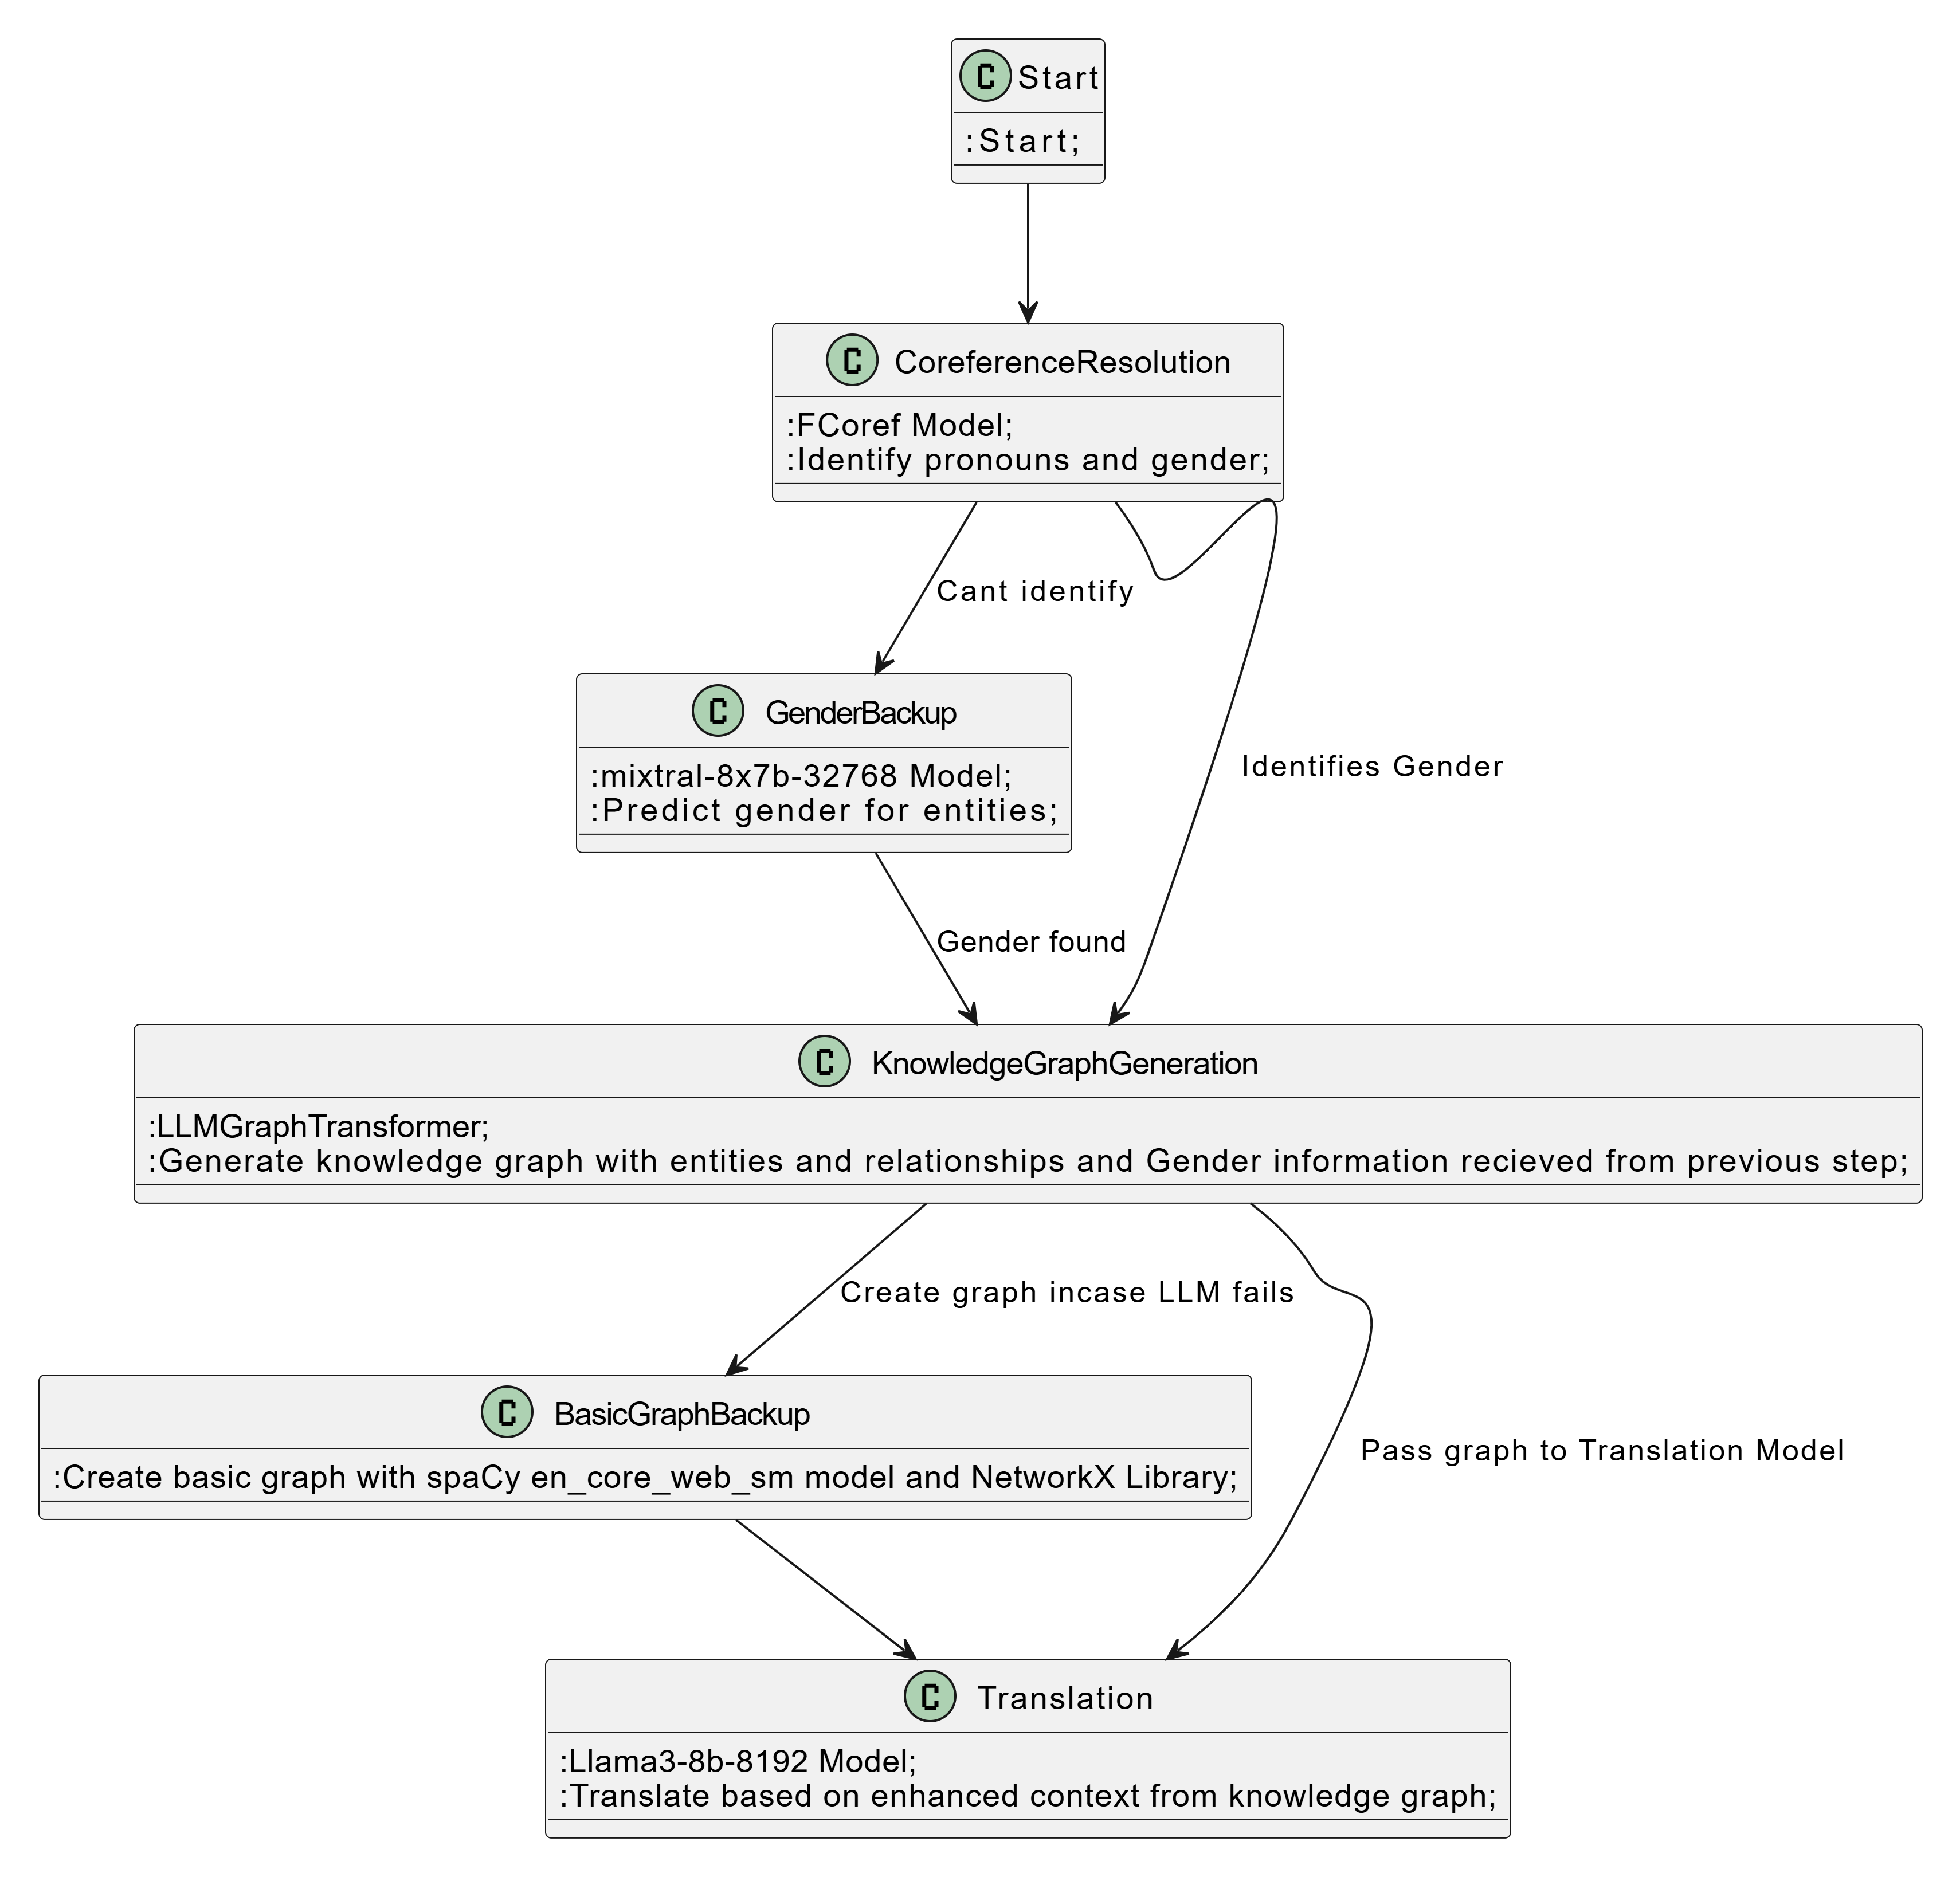

In [ ]:
%%capture
!pip install fastcoref
!pip install spacy networkx matplotlib
!python -m spacy download en_core_web_sm
!pip install --upgrade --quiet  langchain langchain-community langchain-groq
!pip install --upgrade --quiet langchain_experimental

Groq api keys:  
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   
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

In [ ]:
groq_api_key="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"

In [ ]:
# Use mistral model works quite better than gemma

# Main code

In [ ]:
# best example
import os
from langchain_groq import ChatGroq
from langchain_core.documents import Document
from langchain_experimental.graph_transformers import LLMGraphTransformer
import networkx as nx
from typing import List, Dict, Optional
import json
from fastcoref import FCoref

class EnhancedKnowledgeGraphGenerator:
    def __init__(self, api_key: str, model_name: str = "mixtral-8x7b-32768"):
        """Initialize the knowledge graph generator with Groq API and coref model"""
        self.llm = ChatGroq(groq_api_key=api_key, model_name=model_name)
        self.graph_transformer = LLMGraphTransformer(llm=self.llm)
        self.coref_model = FCoref()

    def generate_translation_prompt(self, sample_text: str, knowledge_graph: Dict) -> Dict:

     # Extract metadata from the knowledge graph
     nodes = knowledge_graph.get('nodes', [])
     relationships = knowledge_graph.get('relationships', [])

    # Format nodes
     node_metadata = ', '.join(
        f"{node['id']} (Type: {node['type']}, Gender: {node['gender']})"
        for node in nodes
    )

    # Format relationships
     relationship_metadata = ', '.join(
        f"{rel['source']} --[{rel['type']}]--> {rel['target']}"
        for rel in relationships
    )

    # Construct metadata string
     metadata = f"Knowledge Graph Structure: Nodes: {node_metadata}. Relationships: {relationship_metadata}."

    # Create prompt
     prompt = {
        "role": "user",
        "content": (
            f"Translate to Hindi (Devanagari) using only the gender and relationship context of entities from metadata; reply with only the Hindi text: {sample_text} "
            f"Meta data: {metadata} "
        )
    }

     return prompt

    def identify_genders_coref(self, text: str) -> Dict[str, str]:
        """Identify genders using coreference resolution"""
        gender_map = {}
        try:
            # Get coreference clusters
            preds = self.coref_model.predict(texts=[text])
            clusters = preds[0].get_clusters()

            print("Coreference Clusters:")
            for cluster in clusters:
                print(f"Cluster: {cluster}")

                # Create sets for male and female indicating pronouns
                male_pronouns = {'he', 'him', 'his'}
                female_pronouns = {'she', 'her', 'hers'}

                # Check pronouns in the cluster
                cluster_pronouns = {word.lower() for word in cluster}
                has_male = bool(cluster_pronouns & male_pronouns)
                has_female = bool(cluster_pronouns & female_pronouns)

                # Determine gender based on pronouns
                if has_male and not has_female:
                    gender = 'male'
                elif has_female and not has_male:
                    gender = 'female'
                else:
                    continue  # Skip if no clear gender indicators

                # Assign gender to all non-pronoun entities in the cluster
                for entity in cluster:
                    if (entity.lower() not in male_pronouns and
                        entity.lower() not in female_pronouns and
                        entity[0].isupper()):  # Only proper nouns
                        gender_map[entity] = gender
                        print(f"Assigned {gender} to {entity} based on pronouns")

        except Exception as e:
            print(f"Coreference resolution error: {str(e)}")

        return gender_map

    def identify_gender_llm(self, entity: str, entity_type: str, gender_map: Dict[str, str]) -> str:
        """Use LLM to identify gender when coref fails"""
        # First check if we already have gender from coref
        if entity in gender_map:
            return gender_map[entity]

        if entity_type.lower() != 'person':
            return 'unknown'

        try:
            prompt = f"""
            Analyze the entity name '{entity}' with type '{entity_type}'.
            If it's a person, determine their likely gender based on context.
            Respond with exactly one word: 'male', 'female', or 'unknown'.
            For non-person entities, always respond with 'unknown'.
            """

            response = self.llm.predict(prompt)
            gender = response.lower().strip()

            if gender not in ['male', 'female', 'unknown']:
                return 'unknown'

            return gender

        except Exception as e:
            print(f"LLM gender identification error for {entity}: {str(e)}")
            return 'unknown'

    def create_graph_from_text(self, text: str) -> Dict:
        """Generate a knowledge graph from input text with gender information"""
        try:
            # First pass: Get gender information from coreference resolution
            gender_map = self.identify_genders_coref(text)
            print(f"\nIdentified genders from coref: {gender_map}")

            # Generate base graph
            documents = [Document(page_content=text)]
            graph_documents = self.graph_transformer.convert_to_graph_documents(documents)

            if not graph_documents or not hasattr(graph_documents[0], 'nodes'):
                print("Using Basic Graph Generation.")
                return self._create_basic_graph(text, gender_map)

            print("Using LLM-based Graph Generation.")

            # Create NetworkX graph with gender information
            G = nx.DiGraph()

            # Add nodes with gender information
            for node in graph_documents[0].nodes:
                # Use gender from coref map first, then fallback to LLM
                gender = self.identify_gender_llm(node.id, node.type, gender_map)

                G.add_node(node.id,
                          type=node.type,
                          gender=gender,
                          properties=node.properties)

            # Add relationships
            for rel in graph_documents[0].relationships:
                G.add_edge(
                    rel.source.id,
                    rel.target.id,
                    type=rel.type,
                    properties=rel.properties
                )

            return {
                'nodes': [{
                    'id': n,
                    'type': G.nodes[n]['type'],
                    'gender': G.nodes[n]['gender']
                } for n in G.nodes()],
                'relationships': [{
                    'source': u,
                    'target': v,
                    'type': G.edges[u, v]['type']
                } for u, v in G.edges()]
            }

        except Exception as e:
            print(f"Error in graph generation: {str(e)}")
            return self._create_basic_graph(text, gender_map)

    def _create_basic_graph(self, text: str, gender_map: Dict[str, str]) -> Dict:
        """Backup : Create a basic graph structure with gender information"""
        sentences = text.replace('.', '.#').split('#')
        sentences = [s.strip() for s in sentences if s.strip()]

        G = nx.DiGraph()
        entities = set()

        # Extract basic entities
        for sentence in sentences:
            words = sentence.split()
            for word in words:
                if word[0].isupper() and len(word) > 1:
                    entities.add(word)

        # Add nodes with gender information
        for entity in entities:
            gender = self.identify_gender_llm(entity, 'Entity', gender_map)
            G.add_node(entity, type='Entity', gender=gender)

        # Add basic relationships
        entity_list = list(entities)
        for i in range(len(entity_list) - 1):
            G.add_edge(entity_list[i], entity_list[i + 1], type='RELATED_TO')

        return {
            'nodes': [{
                'id': n,
                'type': 'Entity',
                'gender': G.nodes[n]['gender']
            } for n in G.nodes()],
            'relationships': [{
                'source': u,
                'target': v,
                'type': G.edges[u, v]['type']
            } for u, v in G.edges()]
        }

    def print_graph(self, graph: Dict):
        """Print the knowledge graph in a readable format"""
        print("\nKnowledge Graph Structure:")
        print("\nNodes:")
        for node in graph['nodes']:
            print(f"- {node['id']} (Type: {node['type']}, Gender: {node['gender']})")

        print("\nRelationships:")
        for rel in graph['relationships']:
            print(f"- {rel['source']} --[{rel['type']}]--> {rel['target']}")

# Example usage
if __name__ == "__main__":
    sample_text = "Kiran is a good student and she goes to school."

    # Create graph generator instance
    kg_generator = EnhancedKnowledgeGraphGenerator(groq_api_key)

    # Generate and print the knowledge graph
    graph = kg_generator.create_graph_from_text(sample_text)
    kg_generator.print_graph(graph)
    prompt = kg_generator.generate_translation_prompt(sample_text,graph)
    # print(json.dumps(prompt, indent=4))

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Coreference Clusters:
Cluster: ['Kiran', 'she']
Assigned female to Kiran based on pronouns

Identified genders from coref: {'Kiran': 'female'}
Using LLM-based Graph Generation.

Knowledge Graph Structure:

Nodes:
- Kiran (Type: Student, Gender: female)
- School (Type: Location, Gender: unknown)

Relationships:
- Kiran --[VISITS]--> School


In case Api call fails  
used spacy.load("en_core_web_sm") to create the backup knowledge graph

In [ ]:
# best example
import os
from langchain_groq import ChatGroq
from langchain_core.documents import Document
from langchain_experimental.graph_transformers import LLMGraphTransformer
import networkx as nx
from typing import List, Dict, Optional
import json
from fastcoref import FCoref

class EnhancedKnowledgeGraphGenerator:
    def __init__(self, api_key: str, model_name: str = "mixtral-8x7b-32768"):
        """Initialize the knowledge graph generator with Groq API and coref model"""
        self.llm = ChatGroq(groq_api_key=api_key, model_name=model_name)
        self.graph_transformer = LLMGraphTransformer(llm=self.llm)
        self.coref_model = FCoref()

    def generate_translation_prompt(self, sample_text: str, knowledge_graph: Dict) -> Dict:

     # Extract metadata from the knowledge graph
     nodes = knowledge_graph.get('nodes', [])
     relationships = knowledge_graph.get('relationships', [])

    # Format nodes
     node_metadata = ', '.join(
        f"{node['id']} (Type: {node['type']}, Gender: {node['gender']})"
        for node in nodes
    )

    # Format relationships
     relationship_metadata = ', '.join(
        f"{rel['source']} --[{rel['type']}]--> {rel['target']}"
        for rel in relationships
    )

    # Construct metadata string
     metadata = f"Knowledge Graph Structure: Nodes: {node_metadata}. Relationships: {relationship_metadata}."

    # Create prompt
     prompt = {
        "role": "user",
        "content": (
            f"Translate to Hindi (Devanagari) using only the gender and relationship context of entities from metadata; reply with only the Hindi text: {sample_text} "
            f"Meta data: {metadata} "
        )
    }

     return prompt

    def identify_genders_coref(self, text: str) -> Dict[str, str]:
        """Identify genders using coreference resolution"""
        gender_map = {}
        try:
            # Get coreference clusters
            preds = self.coref_model.predict(texts=[text])
            clusters = preds[0].get_clusters()

            print("Coreference Clusters:")
            for cluster in clusters:
                print(f"Cluster: {cluster}")

                # Create sets for male and female indicating pronouns
                male_pronouns = {'he', 'him', 'his'}
                female_pronouns = {'she', 'her', 'hers'}

                # Check pronouns in the cluster
                cluster_pronouns = {word.lower() for word in cluster}
                has_male = bool(cluster_pronouns & male_pronouns)
                has_female = bool(cluster_pronouns & female_pronouns)

                # Determine gender based on pronouns
                if has_male and not has_female:
                    gender = 'male'
                elif has_female and not has_male:
                    gender = 'female'
                else:
                    continue  # Skip if no clear gender indicators

                # Assign gender to all non-pronoun entities in the cluster
                for entity in cluster:
                    if (entity.lower() not in male_pronouns and
                        entity.lower() not in female_pronouns and
                        entity[0].isupper()):  # Only proper nouns
                        gender_map[entity] = gender
                        print(f"Assigned {gender} to {entity} based on pronouns")

        except Exception as e:
            print(f"Coreference resolution error: {str(e)}")

        return gender_map

    def identify_gender_llm(self, entity: str, entity_type: str, gender_map: Dict[str, str]) -> str:
        """Use LLM to identify gender when coref fails"""
        # First check if we already have gender from coref
        if entity in gender_map:
            return gender_map[entity]

        if entity_type.lower() != 'person':
            return 'unknown'

        try:
            prompt = f"""
            Analyze the entity name '{entity}' with type '{entity_type}'.
            If it's a person, determine their likely gender based on context.
            Respond with exactly one word: 'male', 'female', or 'unknown'.
            For non-person entities, always respond with 'unknown'.
            """

            response = self.llm.predict(prompt)
            gender = response.lower().strip()

            if gender not in ['male', 'female', 'unknown']:
                return 'unknown'

            return gender

        except Exception as e:
            print(f"LLM gender identification error for {entity}: {str(e)}")
            return 'unknown'

    def create_graph_from_text(self, text: str) -> Dict:
        """Generate a knowledge graph from input text with gender information"""
        try:
            # First pass: Get gender information from coreference resolution
            gender_map = self.identify_genders_coref(text)
            print(f"\nIdentified genders from coref: {gender_map}")

            # Generate base graph
            documents = [Document(page_content=text)]
            graph_documents = self.graph_transformer.convert_to_graph_documents(documents)

            if not graph_documents or not hasattr(graph_documents[0], 'nodes'):
                print("Using Basic Graph Generation.")
                return self._create_basic_graph(text, gender_map)

            print("Using LLM-based Graph Generation.")

            # Create NetworkX graph with gender information
            G = nx.DiGraph()

            # Add nodes with gender information
            for node in graph_documents[0].nodes:
                # Use gender from coref map first, then fallback to LLM
                gender = self.identify_gender_llm(node.id, node.type, gender_map)

                G.add_node(node.id,
                          type=node.type,
                          gender=gender,
                          properties=node.properties)

            # Add relationships
            for rel in graph_documents[0].relationships:
                G.add_edge(
                    rel.source.id,
                    rel.target.id,
                    type=rel.type,
                    properties=rel.properties
                )

            return {
                'nodes': [{
                    'id': n,
                    'type': G.nodes[n]['type'],
                    'gender': G.nodes[n]['gender']
                } for n in G.nodes()],
                'relationships': [{
                    'source': u,
                    'target': v,
                    'type': G.edges[u, v]['type']
                } for u, v in G.edges()]
            }

        except Exception as e:
            print(f"Error in graph generation: {str(e)}")
            return self._create_basic_graph(text, gender_map)

    def _create_basic_graph(self, text: str, gender_map: Dict[str, str]) -> Dict:
     """Create a basic graph structure using spaCy NLP and coreference information"""
     try:
        import spacy
        nlp = spacy.load("en_core_web_sm")

        # Process text with spaCy
        doc = nlp(text)
        G = nx.DiGraph()
        entities = set()
        entity_mentions = {}  # Track all mentions of each entity

        # First pass: collect named entities and their mentions
        for ent in doc.ents:
            if ent.label_ in ['PERSON', 'ORG', 'GPE', 'NORP', 'FAC']:
                clean_ent = ent.text.strip()
                entities.add(clean_ent)
                if clean_ent not in entity_mentions:
                    entity_mentions[clean_ent] = []
                entity_mentions[clean_ent].append({
                    'text': ent.text,
                    'start': ent.start_char,
                    'end': ent.end_char,
                    'label': ent.label_
                })

        # Add nodes with enhanced type detection and gender information
        for entity in entities:
            # Determine entity type from spaCy
            entity_type = 'Entity'  # default
            if entity in entity_mentions:
                mentions = entity_mentions[entity]
                if mentions:
                    entity_type = mentions[0]['label']

            # Get gender information, prioritizing the coref map
            gender = gender_map.get(entity, None)
            if gender is None:
                gender = self.identify_gender_llm(entity, entity_type, gender_map)

            G.add_node(entity, type=entity_type, gender=gender)

        # Extract relationships using dependency parsing
        for sent in doc.sents:
            for token in sent:
                if token.dep_ in ['nsubj', 'nsubjpass', 'dobj', 'pobj']:
                    # Get the head (predicate) and dependent (argument)
                    head = token.head.text
                    dep = token.text

                    # Check if either the head or dependent is in our entities
                    source_entity = None
                    target_entity = None

                    # Find the containing entity for the dependent
                    for ent in entities:
                        if dep in ent or ent in dep:
                            target_entity = ent
                            break

                    # Find any entity that contains the head verb's subject
                    for token2 in sent:
                        if token2.dep_ == 'nsubj' and token2.head == token.head:
                            for ent in entities:
                                if token2.text in ent or ent in token2.text:
                                    source_entity = ent
                                    break

                    # Add edge if we found both entities
                    if source_entity and target_entity and source_entity != target_entity:
                        relation_type = token.head.text.upper()
                        G.add_edge(source_entity, target_entity,
                                 type=f'REL_{relation_type}')

        # Add relationships based on coreference clusters if not enough found
        if len(G.edges()) < len(entities) - 1:
            entity_list = list(entities)
            for i in range(len(entity_list) - 1):
                source = entity_list[i]
                target = entity_list[i + 1]
                if not G.has_edge(source, target):
                    G.add_edge(source, target, type='RELATED_TO')

        return {
            'nodes': [{
                'id': n,
                'type': G.nodes[n]['type'],
                'gender': G.nodes[n]['gender']
            } for n in G.nodes()],
            'relationships': [{
                'source': u,
                'target': v,
                'type': G.edges[u, v]['type']
            } for u, v in G.edges()]
        }

     except Exception as e:
        print(f"Error in basic graph generation: {str(e)}")
        # Fallback to extremely basic graph if spaCy fails
        G = nx.DiGraph()
        words = [w for w in text.split() if w[0].isupper()]
        for word in words:
            G.add_node(word, type='Entity',
                      gender=gender_map.get(word, 'unknown'))
        for i in range(len(words) - 1):
            G.add_edge(words[i], words[i + 1], type='RELATED_TO')

        return {
            'nodes': [{
                'id': n,
                'type': 'Entity',
                'gender': G.nodes[n]['gender']
            } for n in G.nodes()],
            'relationships': [{
                'source': u,
                'target': v,
                'type': G.edges[u, v]['type']
            } for u, v in G.edges()]
        }

    def print_graph(self, graph: Dict):
        """Print the knowledge graph in a readable format"""
        print("\nKnowledge Graph Structure:")
        print("\nNodes:")
        for node in graph['nodes']:
            print(f"- {node['id']} (Type: {node['type']}, Gender: {node['gender']})")

        print("\nRelationships:")
        for rel in graph['relationships']:
            print(f"- {rel['source']} --[{rel['type']}]--> {rel['target']}")

# Example usage
if __name__ == "__main__":
    sample_text = "Kiran is a good student and she goes to school."

    # Create graph generator instance
    kg_generator = EnhancedKnowledgeGraphGenerator(groq_api_key)

    # Generate and print the knowledge graph
    graph = kg_generator.create_graph_from_text(sample_text)
    kg_generator.print_graph(graph)
    prompt = kg_generator.generate_translation_prompt(sample_text,graph)
    # print(json.dumps(prompt, indent=4))

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Coreference Clusters:
Cluster: ['Kiran', 'she']
Assigned female to Kiran based on pronouns

Identified genders from coref: {'Kiran': 'female'}
Error in graph generation: Error code: 401 - {'error': {'message': 'Invalid API Key', 'type': 'invalid_request_error', 'code': 'invalid_api_key'}}

Knowledge Graph Structure:

Nodes:
- Kiran (Type: PERSON, Gender: female)

Relationships:


In [ ]:
prompt

{'role': 'user',
 'content': 'Translate to Hindi (Devanagari) using only the gender and relationship context of entities from metadata; reply with only the Hindi text: Kiran is a good student and she goes to school. Meta data: Knowledge Graph Structure: Nodes: Kiran (Type: Student, Gender: female), School (Type: Location, Gender: unknown). Relationships: Kiran --[VISITS]--> School. '}

#Normal output

In [ ]:
# normal output

import os
from groq import Groq

# Initialize Groq client with API key
client = Groq(
    api_key="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"
)

# Create the chat completion with dynamic content
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": f"Translate this in Hindi and send only the hindi translated part: {sample_text}",
        }
    ],
    model="llama3-8b-8192",
)

# Print the translated output
print(chat_completion.choices[0].message.content)

किरण एक अच्छा छात्र है और वह स्कूल जाती है।


# Output using Coreference and Knowledge graph data as meta data

In [ ]:
# Dynamic prompt integration
import os
from groq import Groq

# Initialize Groq client with API key
client = Groq(
    api_key="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"
)

# Using the prompt generated from the previous code
chat_completion = client.chat.completions.create(
    messages=[prompt],  # Use the dynamically generated prompt here
    model="llama3-8b-8192",
)

# Print the translated output
print(chat_completion.choices[0].message.content)


किरन एक अच्छी छात्र हैं और वह स्कूल जाती हैं.


#Test2 along with visualization of the output graph

In [ ]:
# best example
import os
from langchain_groq import ChatGroq
from langchain_core.documents import Document
from langchain_experimental.graph_transformers import LLMGraphTransformer
import networkx as nx
from typing import List, Dict, Optional
import json
from fastcoref import FCoref

class EnhancedKnowledgeGraphGenerator:
    def __init__(self, api_key: str, model_name: str = "mixtral-8x7b-32768"):
        """Initialize the knowledge graph generator with Groq API and coref model"""
        self.llm = ChatGroq(groq_api_key=api_key, model_name=model_name)
        self.graph_transformer = LLMGraphTransformer(llm=self.llm)
        self.coref_model = FCoref()

    def generate_translation_prompt(self, sample_text: str, knowledge_graph: Dict) -> Dict:

     # Extract metadata from the knowledge graph
     nodes = knowledge_graph.get('nodes', [])
     relationships = knowledge_graph.get('relationships', [])

    # Format nodes
     node_metadata = ', '.join(
        f"{node['id']} (Type: {node['type']}, Gender: {node['gender']})"
        for node in nodes
    )

    # Format relationships
     relationship_metadata = ', '.join(
        f"{rel['source']} --[{rel['type']}]--> {rel['target']}"
        for rel in relationships
    )

    # Construct metadata string
     metadata = f"Knowledge Graph Structure: Nodes: {node_metadata}. Relationships: {relationship_metadata}."

    # Create prompt
     prompt = {
        "role": "user",
        "content": (
            f"Translate to Hindi (Devanagari) using only the gender and relationship context of entities from metadata; reply with only the Hindi text: {sample_text} "
            f"Meta data: {metadata} "
        )
    }

     return prompt

    def identify_genders_coref(self, text: str) -> Dict[str, str]:
        """Identify genders using coreference resolution"""
        gender_map = {}
        try:
            # Get coreference clusters
            preds = self.coref_model.predict(texts=[text])
            clusters = preds[0].get_clusters()

            print("Coreference Clusters:")
            for cluster in clusters:
                print(f"Cluster: {cluster}")

                # Create sets for male and female indicating pronouns
                male_pronouns = {'he', 'him', 'his'}
                female_pronouns = {'she', 'her', 'hers'}

                # Check pronouns in the cluster
                cluster_pronouns = {word.lower() for word in cluster}
                has_male = bool(cluster_pronouns & male_pronouns)
                has_female = bool(cluster_pronouns & female_pronouns)

                # Determine gender based on pronouns
                if has_male and not has_female:
                    gender = 'male'
                elif has_female and not has_male:
                    gender = 'female'
                else:
                    continue  # Skip if no clear gender indicators

                # Assign gender to all non-pronoun entities in the cluster
                for entity in cluster:
                    if (entity.lower() not in male_pronouns and
                        entity.lower() not in female_pronouns and
                        entity[0].isupper()):  # Only proper nouns
                        gender_map[entity] = gender
                        print(f"Assigned {gender} to {entity} based on pronouns")

        except Exception as e:
            print(f"Coreference resolution error: {str(e)}")

        return gender_map

    def identify_gender_llm(self, entity: str, entity_type: str, gender_map: Dict[str, str]) -> str:
        """Use LLM to identify gender when coref fails"""
        # First check if we already have gender from coref
        if entity in gender_map:
            return gender_map[entity]

        if entity_type.lower() != 'person':
            return 'unknown'

        try:
            prompt = f"""
            Analyze the entity name '{entity}' with type '{entity_type}'.
            If it's a person, determine their likely gender based on context.
            Respond with exactly one word: 'male', 'female', or 'unknown'.
            For non-person entities, always respond with 'unknown'.
            """

            response = self.llm.predict(prompt)
            gender = response.lower().strip()

            if gender not in ['male', 'female', 'unknown']:
                return 'unknown'

            return gender

        except Exception as e:
            print(f"LLM gender identification error for {entity}: {str(e)}")
            return 'unknown'

    def create_graph_from_text(self, text: str) -> Dict:
        """Generate a knowledge graph from input text with gender information"""
        try:
            # First pass: Get gender information from coreference resolution
            gender_map = self.identify_genders_coref(text)
            print(f"\nIdentified genders from coref: {gender_map}")

            # Generate base graph
            documents = [Document(page_content=text)]
            graph_documents = self.graph_transformer.convert_to_graph_documents(documents)

            if not graph_documents or not hasattr(graph_documents[0], 'nodes'):
                print("Using Basic Graph Generation.")
                return self._create_basic_graph(text, gender_map)

            print("Using LLM-based Graph Generation.")

            # Create NetworkX graph with gender information
            G = nx.DiGraph()

            # Add nodes with gender information
            for node in graph_documents[0].nodes:
                # Use gender from coref map first, then fallback to LLM
                gender = self.identify_gender_llm(node.id, node.type, gender_map)

                G.add_node(node.id,
                          type=node.type,
                          gender=gender,
                          properties=node.properties)

            # Add relationships
            for rel in graph_documents[0].relationships:
                G.add_edge(
                    rel.source.id,
                    rel.target.id,
                    type=rel.type,
                    properties=rel.properties
                )

            return {
                'nodes': [{
                    'id': n,
                    'type': G.nodes[n]['type'],
                    'gender': G.nodes[n]['gender']
                } for n in G.nodes()],
                'relationships': [{
                    'source': u,
                    'target': v,
                    'type': G.edges[u, v]['type']
                } for u, v in G.edges()]
            }

        except Exception as e:
            print(f"Error in graph generation: {str(e)}")
            return self._create_basic_graph(text, gender_map)

    def _create_basic_graph(self, text: str, gender_map: Dict[str, str]) -> Dict:
        """Backup : Create a basic graph structure with gender information"""
        sentences = text.replace('.', '.#').split('#')
        sentences = [s.strip() for s in sentences if s.strip()]

        G = nx.DiGraph()
        entities = set()

        # Extract basic entities
        for sentence in sentences:
            words = sentence.split()
            for word in words:
                if word[0].isupper() and len(word) > 1:
                    entities.add(word)

        # Add nodes with gender information
        for entity in entities:
            gender = self.identify_gender_llm(entity, 'Entity', gender_map)
            G.add_node(entity, type='Entity', gender=gender)

        # Add basic relationships
        entity_list = list(entities)
        for i in range(len(entity_list) - 1):
            G.add_edge(entity_list[i], entity_list[i + 1], type='RELATED_TO')

        return {
            'nodes': [{
                'id': n,
                'type': 'Entity',
                'gender': G.nodes[n]['gender']
            } for n in G.nodes()],
            'relationships': [{
                'source': u,
                'target': v,
                'type': G.edges[u, v]['type']
            } for u, v in G.edges()]
        }

    def print_graph(self, graph: Dict):
        """Print the knowledge graph in a readable format"""
        print("\nKnowledge Graph Structure:")
        print("\nNodes:")
        for node in graph['nodes']:
            print(f"- {node['id']} (Type: {node['type']}, Gender: {node['gender']})")

        print("\nRelationships:")
        for rel in graph['relationships']:
            print(f"- {rel['source']} --[{rel['type']}]--> {rel['target']}")



Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Coreference Clusters:
Cluster: ['Kiran', 'his', 'kirans']
Assigned male to Kiran based on pronouns
Cluster: ['Sita', 'he']
Assigned male to Sita based on pronouns

Identified genders from coref: {'Kiran': 'male', 'Sita': 'male'}
Using LLM-based Graph Generation.


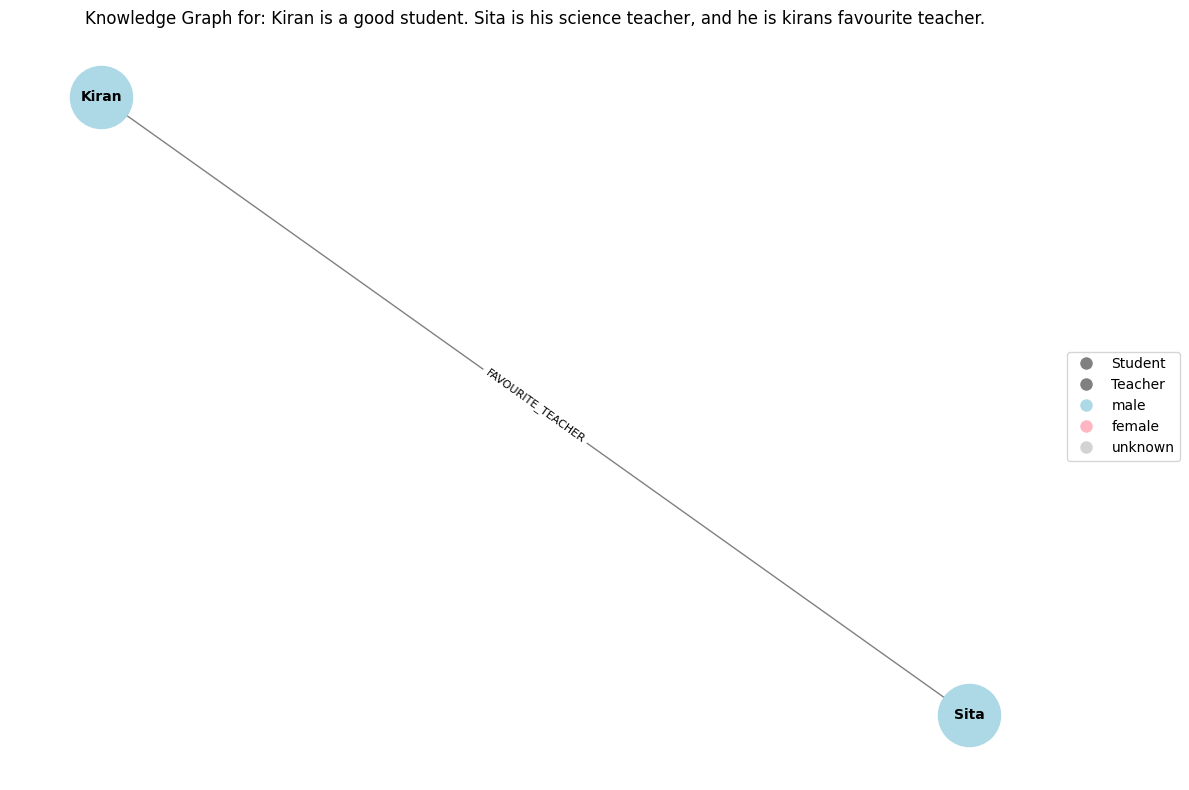

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from typing import Dict
import random

class KnowledgeGraphVisualizer:
    def __init__(self):
        """Initialize the visualizer with color schemes"""
        self.gender_colors = {
            'male': '#ADD8E6',    # Light blue
            'female': '#FFB6C1',  # Light pink
            'unknown': '#D3D3D3'  # Light gray
        }

        self.type_markers = {
            'Person': 'o',      # Circle
            'Location': 's',    # Square
            'Organization': '^', # Triangle
            'Entity': 'D'       # Diamond (default)
        }

    def create_visualization(self, graph: Dict, title: str = "Knowledge Graph Visualization"):
        """Create and display a visualization of the knowledge graph"""
        # Create a new directed graph
        G = nx.DiGraph()

        # Add nodes with attributes
        for node in graph['nodes']:
            G.add_node(
                node['id'],
                gender=node.get('gender', 'unknown'),
                type=node.get('type', 'Entity')
            )

        # Add edges with relationship types
        for rel in graph['relationships']:
            G.add_edge(
                rel['source'],
                rel['target'],
                relationship=rel['type']
            )

        # Set up the plot
        plt.figure(figsize=(12, 8))

        # Create the layout
        pos = nx.spring_layout(G, k=1, iterations=50)

        # Draw nodes
        for node_type in set(nx.get_node_attributes(G, 'type').values()):
            node_list = [node for node, attr in G.nodes(data=True)
                        if attr.get('type') == node_type]

            if node_list:
                nx.draw_networkx_nodes(
                    G, pos,
                    nodelist=node_list,
                    node_color=[self.gender_colors[G.nodes[node]['gender']]
                              for node in node_list],
                    node_size=2000,
                    node_shape=self.type_markers.get(node_type, 'o'),
                    label=node_type
                )

        # Draw edges
        edge_labels = nx.get_edge_attributes(G, 'relationship')
        nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=20)

        # Add labels
        nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
        nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)

        # Add legend for node types
        legend_elements = [plt.Line2D([0], [0], marker=self.type_markers.get(node_type, 'o'),
                                    color='w', markerfacecolor='gray', markersize=10,
                                    label=node_type)
                         for node_type in set(nx.get_node_attributes(G, 'type').values())]

        # Add legend for genders
        legend_elements.extend([plt.Line2D([0], [0], marker='o',
                                         color='w', markerfacecolor=color, markersize=10,
                                         label=gender)
                              for gender, color in self.gender_colors.items()])

        plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

        # Set title and layout
        plt.title(title)
        plt.axis('off')
        plt.tight_layout()

        # Show the plot
        plt.show()

if __name__ == "__main__":
    # Your existing code
    kg_generator = EnhancedKnowledgeGraphGenerator(groq_api_key)

    # Generate the knowledge graph
    sample_text = "Kiran is a good student. Sita is his science teacher, and he is kirans favourite teacher."
    graph = kg_generator.create_graph_from_text(sample_text)
    prompt = kg_generator.generate_translation_prompt(sample_text,graph)
    # Create and display visualization
    visualizer = KnowledgeGraphVisualizer()
    visualizer.create_visualization(graph, f"Knowledge Graph for: {sample_text}")

In [ ]:
prompt

{'role': 'user',
 'content': 'Translate to Hindi (Devanagari) using only the gender and relationship context of entities from metadata; reply with only the Hindi text: Kiran is a good student. Sita is his science teacher, and he is kirans favourite teacher. Meta data: Knowledge Graph Structure: Nodes: Kiran (Type: Student, Gender: male), Sita (Type: Teacher, Gender: male). Relationships: Kiran --[FAVOURITE_TEACHER]--> Sita. '}

In [ ]:
# normal output

import os
from groq import Groq

# Initialize Groq client with API key
client = Groq(
    api_key="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"
)

# Create the chat completion with dynamic content
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": f"Translate this in Hindi and send only the hindi translated part: {sample_text}",
        }
    ],
    model="llama3-8b-8192",
)

# Print the translated output
print(chat_completion.choices[0].message.content)

किरन एक अच्छा विद्यार्थी है. सीता उसका विज्ञान शिक्षक है और वह किरन की पसंदीदा शिक्षक है.


In [ ]:
# Dynamic prompt integration
import os
from groq import Groq

# Initialize Groq client with API key
client = Groq(
    api_key="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"
)

# Using the prompt generated from the previous code
chat_completion = client.chat.completions.create(
    messages=[prompt],  # Use the dynamically generated prompt here
    model="llama-3.1-8b-instant",
)

# Print the translated output
print(chat_completion.choices[0].message.content)


किरण एक अच्छा छात्र है। सीता उनका विज्ञान शिक्षक है, और वह किरण का प्रिय शिक्षक है।


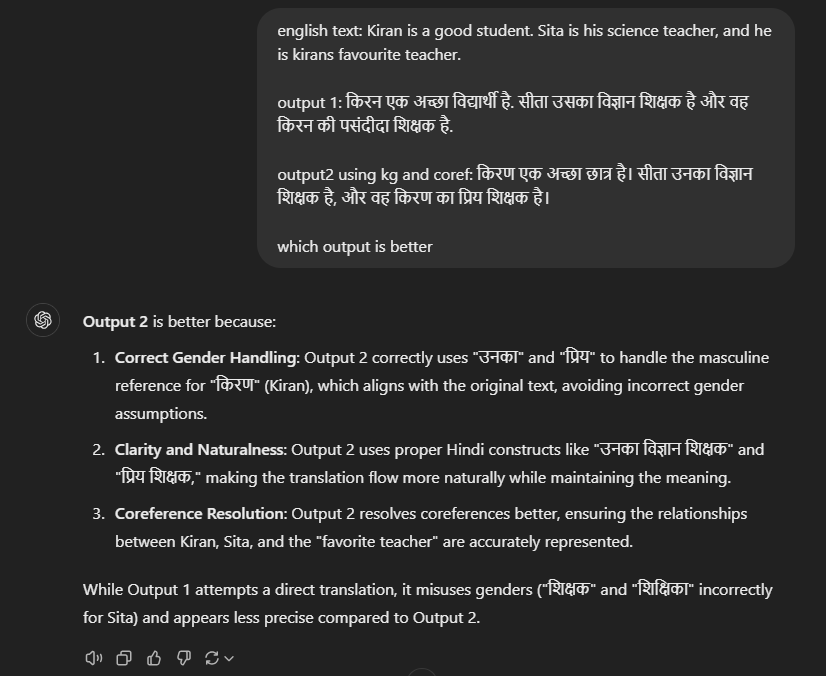

##Manual KG + fast coref (already in use)

In [ ]:
%%capture
pip install fastcoref

In [ ]:
import spacy
import networkx as nx
from fastcoref import FCoref

# Initialize the coreference model
coref_model = FCoref()

# Define the sample sentence
sentence = "Kiran is a good student. Sita is his science teacher, and he is kirans favourite teacher."

# Predict coreference resolution for the sentence
preds = coref_model.predict(texts=[sentence])

# Retrieve the coreference clusters from the prediction
clusters = preds[0].get_clusters()

# Create a mapping for the coreference clusters
coref_mapping = {}
for cluster in clusters:
    for mention in cluster:
        coref_mapping[mention] = cluster[0]  # Map all mentions to the first mention in the cluster

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Process the sentence with spaCy
doc = nlp(sentence)

# Create a directed graph for the Knowledge Graph
G = nx.DiGraph()

# Add nodes and edges based on dependencies and coreference resolution
for token in doc:
    # Replace mentions in the sentence with their coreference heads
    if token.text in coref_mapping:
        token_text = coref_mapping[token.text]
    else:
        token_text = token.text

    # Add entities to graph as nodes
    G.add_node(token_text)

    if token.dep_ != 'punct' and token.head != token:
        # Add edges based on dependency relations
        if coref_mapping.get(token.head.text, token.head.text) != token_text:  # Prevent self-loop
            G.add_edge(coref_mapping.get(token.head.text, token.head.text), token_text, relation=token.dep_)

# Print the Knowledge Graph in text format
print("Knowledge Graph:")
for u, v, data in G.edges(data=True):
    print(f"{u} --[{data['relation']}]--> {v}")


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Knowledge Graph:
is --[nsubj]--> Kiran
is --[attr]--> student
is --[nsubj]--> Sita
is --[attr]--> teacher
is --[cc]--> and
student --[det]--> a
student --[amod]--> good
teacher --[nmod]--> Kiran
teacher --[compound]--> science
teacher --[amod]--> favourite


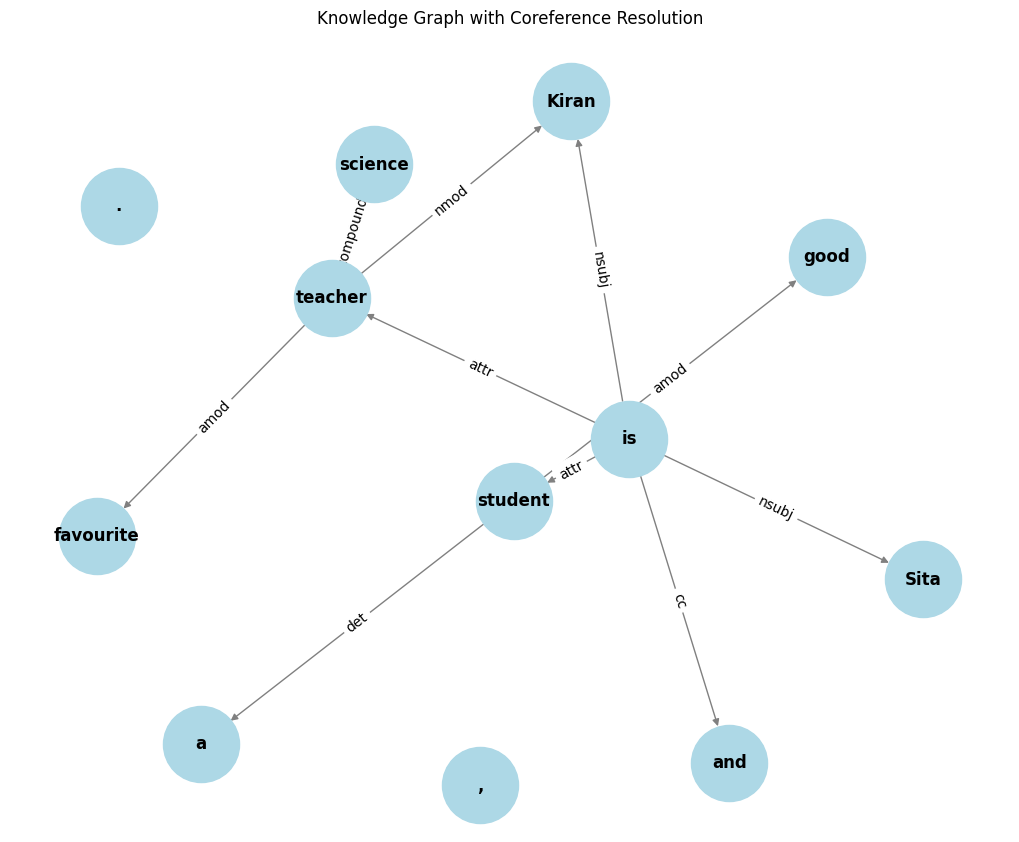

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Visualize the Knowledge Graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # for consistent layout
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=12, font_weight='bold', edge_color='gray')
labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Knowledge Graph with Coreference Resolution")
plt.show()


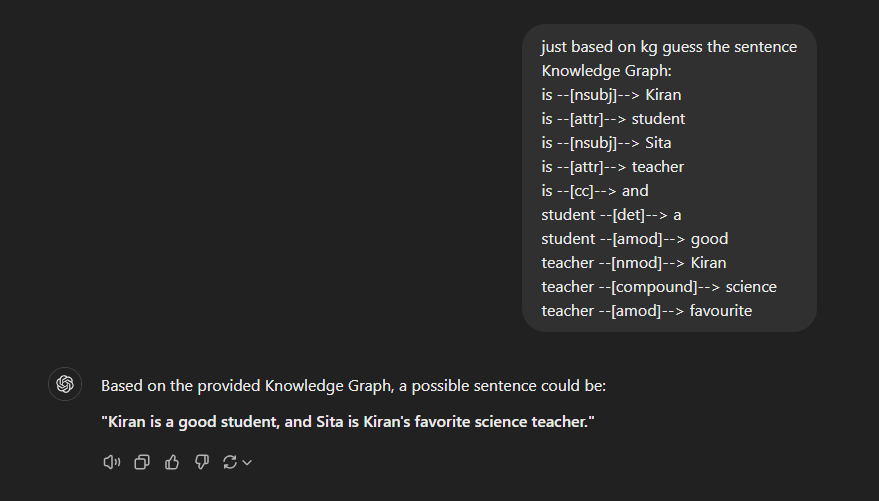